In [6]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
def create_lags(df: pd.DataFrame, col: str, n_lags: int):
    """
    Generate lagged features for a specified column
    """
    lagged_cols = []

    for lag in range(1, 1 + n_lags):
        df[f'Lag_{lag}_{col}'] = df[col].shift(lag)
        lagged_cols.append(f'Lag_{lag}_{col}')

    return lagged_cols

def scale_columns(df, window:int=10, inplace:bool = False):
    # Scale columns with large/values
    cols_to_scale = ['Close', 'High', 'Low', 'Open', 'Volume']

    if not inplace:
        df = df.copy()

    # Apply rolling standard scaling for each column
    for col in cols_to_scale:
        rolling_mean = df[col].rolling(window=window).mean().shift(1)
        rolling_std = df[col].rolling(window=window).std().shift(1)
        df[f'{col}_scaled'] = (df[col] - rolling_mean) / rolling_std

    for col in cols_to_scale:
        df[col] = df[f'{col}_scaled']
        df.drop(columns=[f'{col}_scaled'], inplace=True)
        df = df.dropna()

    return df

In [8]:
def preprocess_data(df, inplace=False):
    if not inplace:
        df = df.copy()

    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    create_lags(df, 'Returns', 5)
    df = df.dropna()
    df['Directions'] = np.sign(df['Returns']).astype(int)
    
    # Here the target variables are the next day's values
    df['Target'] = df['Directions'].shift(-1)
    df['Target_Returns'] = df['Returns'].shift(-1)
    
    df = df.dropna()
    df = scale_columns(df, 10)
    return df

def stock_train_test_split(df):
    feature_cols = ['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Lag_1_Returns', 'Lag_2_Returns',
           'Lag_3_Returns', 'Lag_4_Returns', 'Lag_5_Returns']
    train_data = df.loc[:'2024-02-28'].copy()
    test_data = df.loc['2024-02-29':].copy()
    return (train_data[feature_cols], test_data[feature_cols], train_data[['Target', 'Target_Returns']] , test_data[['Target', 'Target_Returns']])


In [9]:
seed = 12345
data = pd.read_csv(file_path, parse_dates=True, index_col=0).dropna()
idx = data.loc['2024-03-01':].index
close_price = data.loc['2024-03-01':]['Close']

def fit_and_predict_models(stock, X_train, X_test, y_train, y_test, save_to=None):
    df_result = pd.DataFrame() if not save_to else save_to
    if stock == "BA":
        model = LinearRegression()
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test['pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())
    
    if stock == "GS":
        model = RandomForestClassifier(n_estimators=100, random_state=seed)
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test['pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())
        
        
    if stock == "SOFI":
        model = LinearRegression()
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test[f'pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())
        
    if stock == "UNH":
        model = LinearRegression()
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test['pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())
        

    # Compute benchmark cumulative returns
    benchmark_ret = y_test['Target_Returns']
    df_result['cum_ret_benchmark'] = np.exp(benchmark_ret.cumsum())
    
    # As the target variables that we defined above are the next day's values, we need to revert it back
    df_result.index = idx
    # df_result.to_csv('Predictions of ' + stock + '.csv')
    return df_result

In [10]:
def strategy(file_path):
    data = pd.read_csv(file_path, parse_dates=True, index_col=0).dropna()
    data = preprocess_data(data)
    data = data.drop(columns=['Stock Splits'])
    
    X_train, X_test, y_train, y_test = stock_train_test_split(data)
    df_result = fit_and_predict_models(stock, X_train, X_test, y_train, y_test)
    df_result['Close'] = close_price

    # Plot Close Price and Position
    ax = df_result[['Close', 'pos']].plot(figsize=(16,9), secondary_y='pos')
    ax.set_title("Close Price and Position for " + stock)

    # Plot Cumulative Returns
    plt.figure(figsize = (12,6))
    plt.plot(df_result[['Cumulative_Return_Strategy']], label='Cumulative Return of Strategy')
    plt.plot(df_result[['cum_ret_benchmark']], label='Cumulative Return Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns for ' + stock)
    plt.legend();

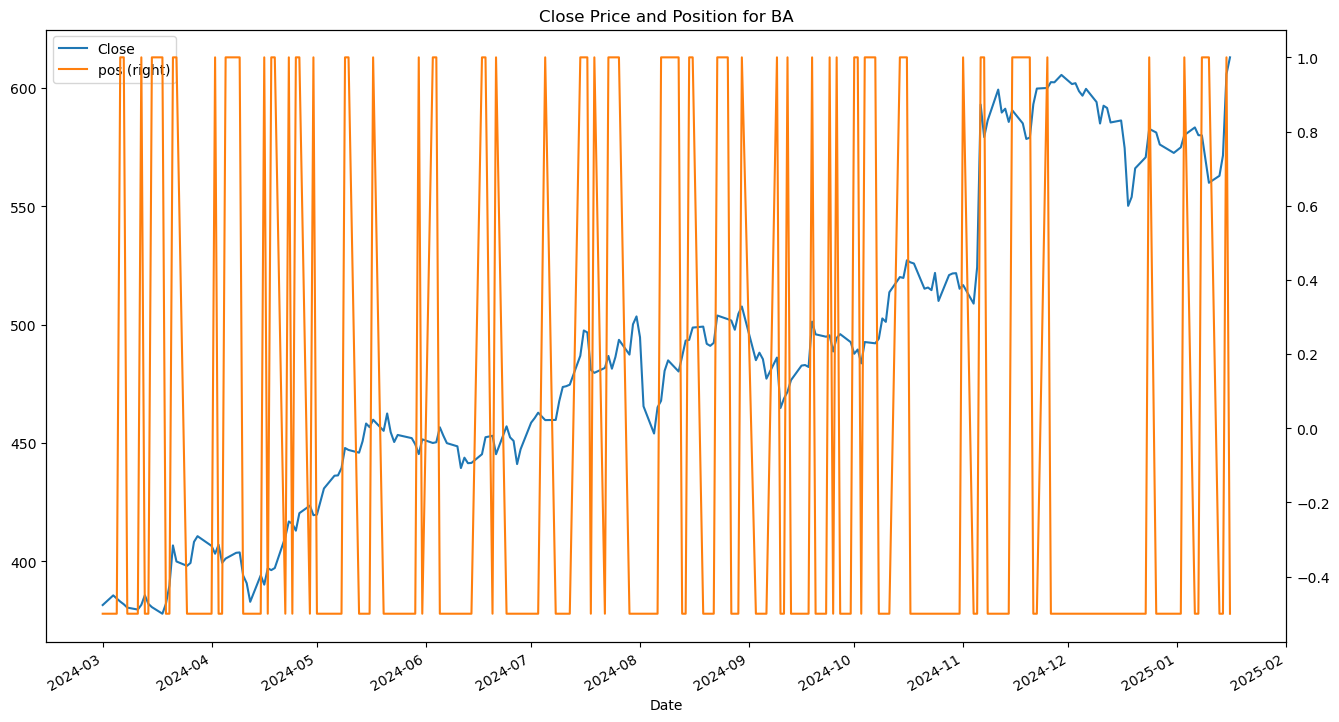

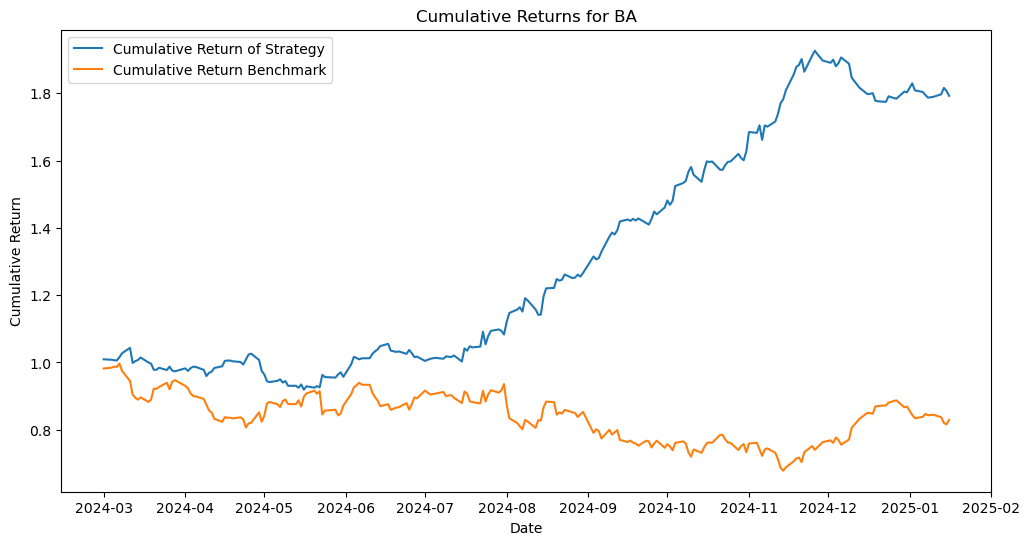

In [11]:
stock = 'BA'
file_path = '../'+ stock + '/' + stock +'.csv'
strategy(file_path)

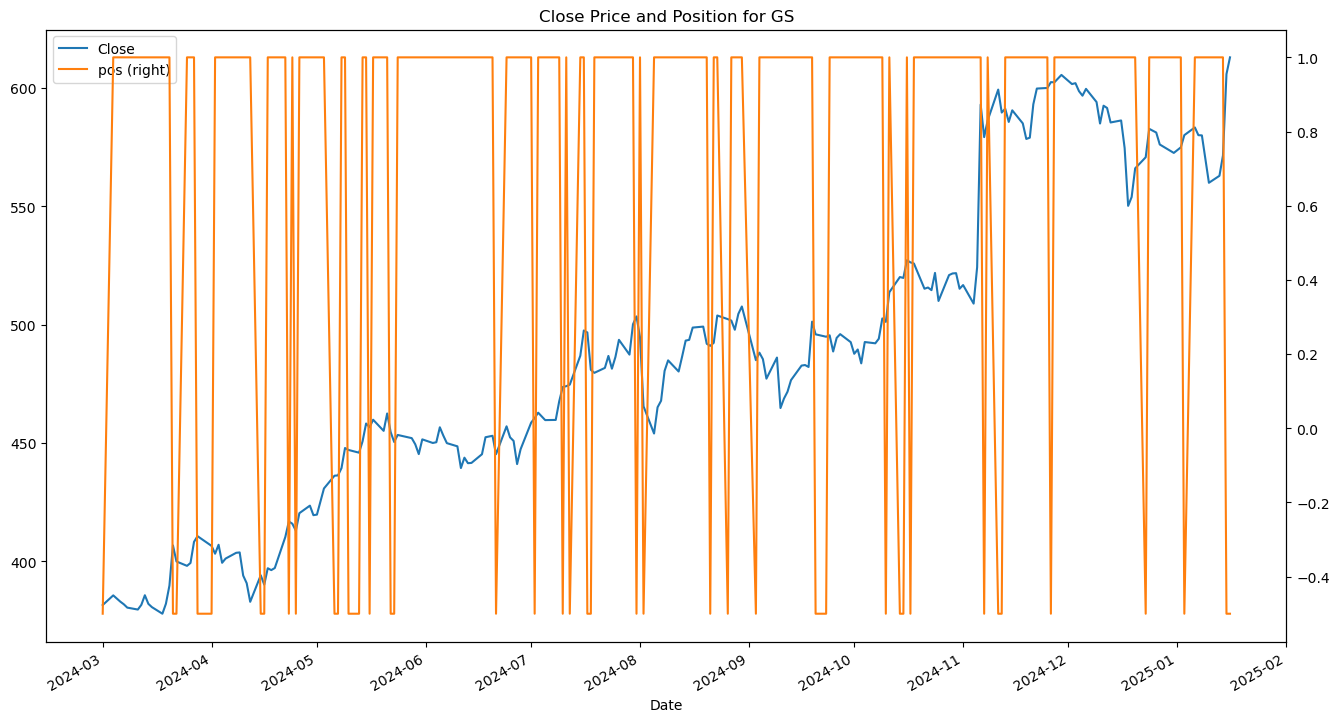

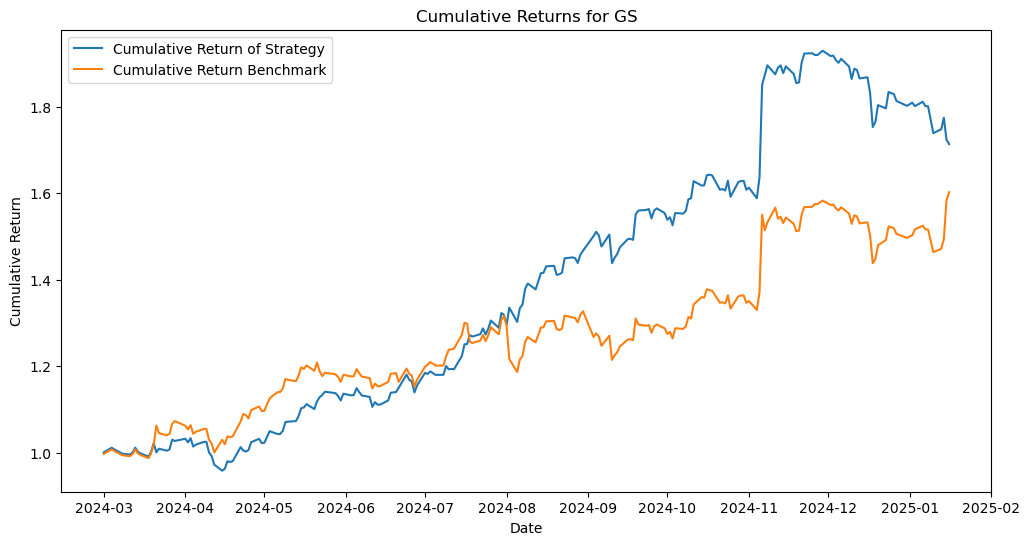

In [12]:
stock = 'GS'
file_path = '../'+ stock + '/' + stock +'.csv'
strategy(file_path)

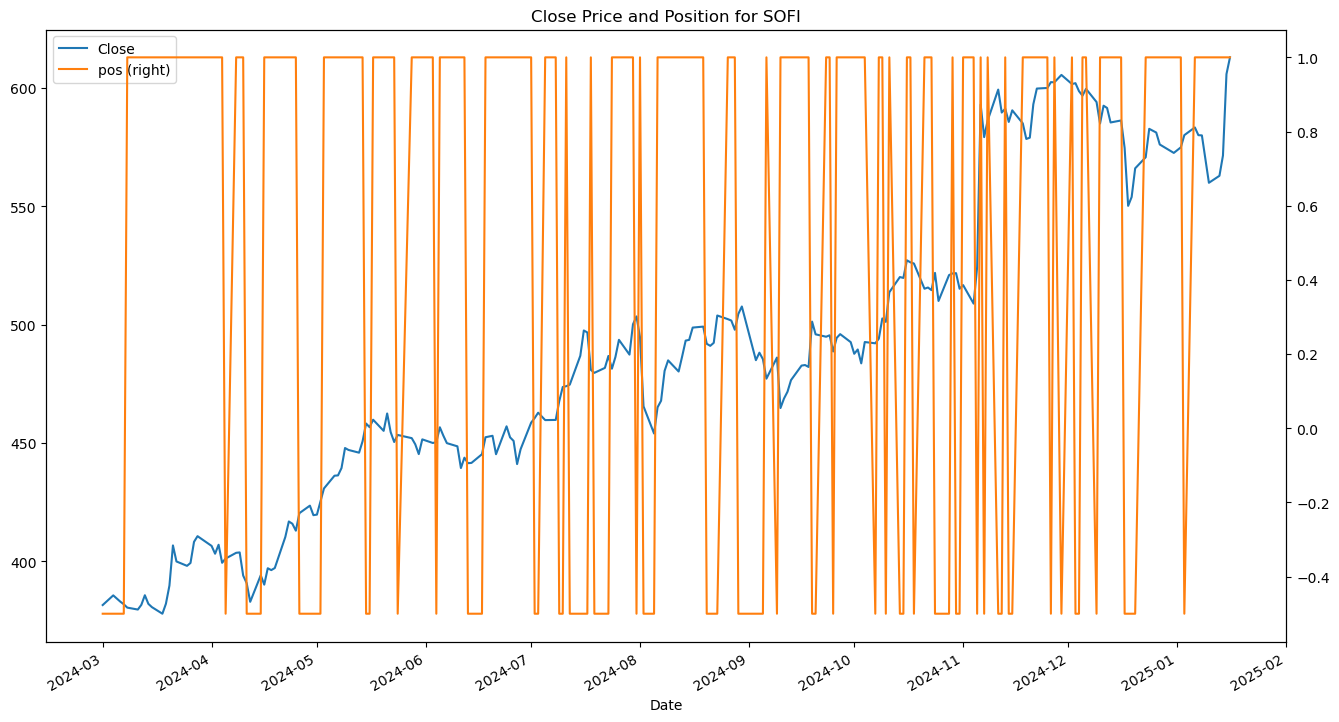

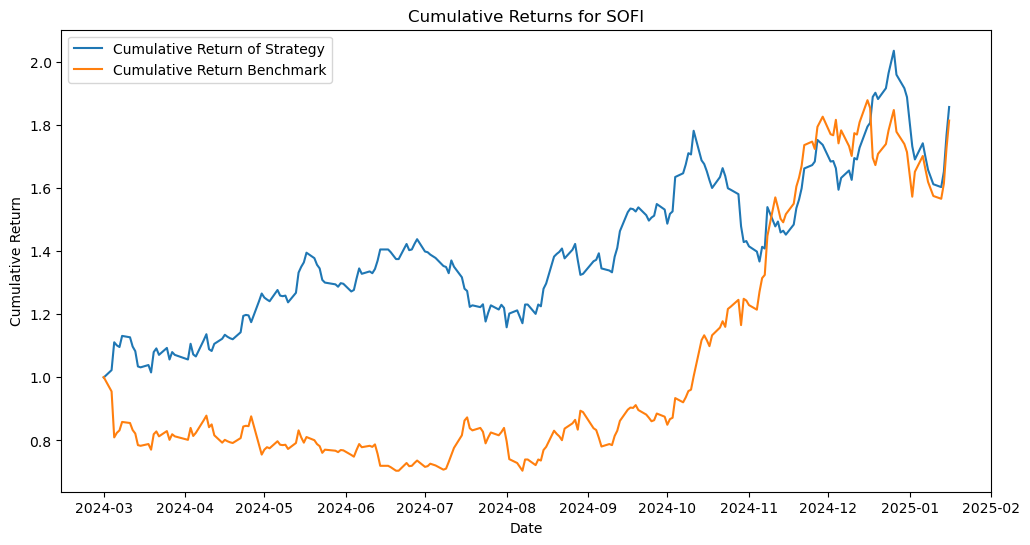

In [13]:
stock = 'SOFI'
file_path = '../'+ stock + '/' + stock +'.csv'
strategy(file_path)

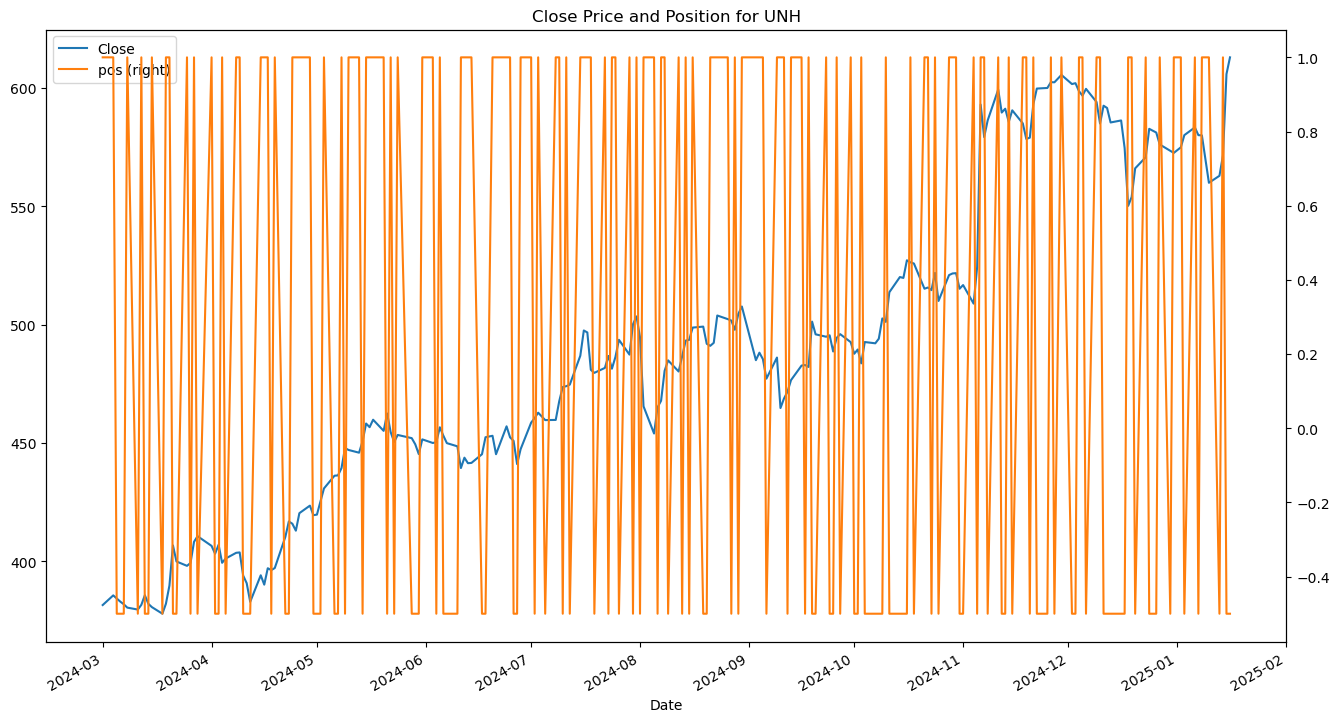

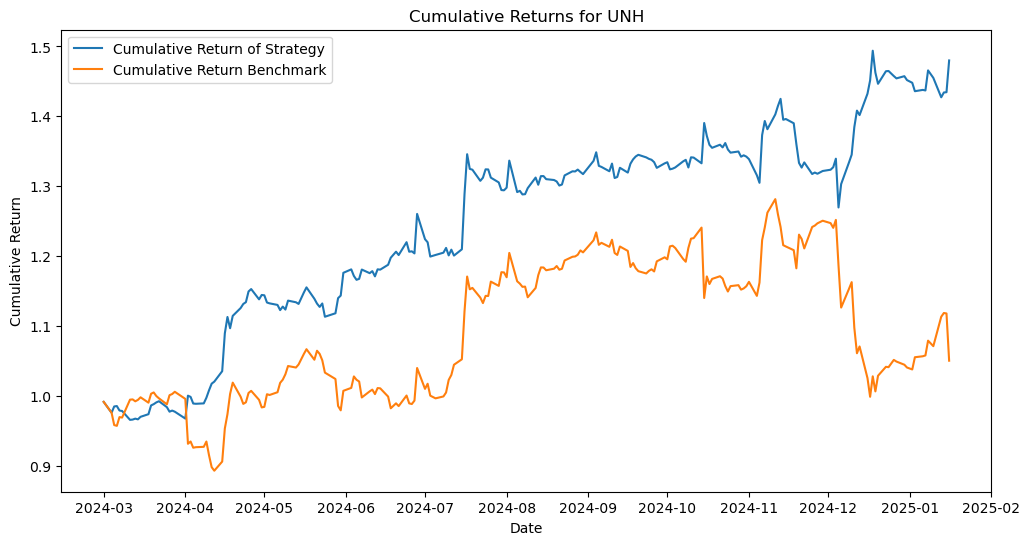

In [14]:
stock = 'UNH'
file_path = '../'+ stock + '/' + stock +'.csv'
strategy(file_path)